# 10,000 bitcoin network

This lab will dig into the fates of the bitcoin transactions tied to [the infamous 10,000 bitcoin pizza](https://en.bitcoin.it/wiki/Laszlo_Hanyecz).  

This code is based on [code originally written](https://gist.github.com/allenday/1207a2c0b962d65b101d1e753ebc1c52) by [Allen Day](https://twitter.com/allenday) and modified by Sohien Dane and Meg Risdal from these Kaggle kernels (parts [1](https://www.kaggle.com/sohier/tracing-the-10-000-btc-pizza/), [2](https://www.kaggle.com/sohier/pizza-btc-post-processing/), [3](https://www.kaggle.com/mrisdal/visualizing-the-10k-btc-pizza-transaction-network)). It will be used to visualize a directed graph representing Bitcoin transactions that follow the first known exchange of Bitcoin for goods on May 17, 2010 made by [Laszlo Hanyecz](https://en.bitcoin.it/wiki/Laszlo_Hanyecz).

In this lab, we will:
1. Retrieve as many transactions as possible from BigQuery within 2 degrees of separation from the pizza exchange. 
- Post-process the transactions to remove excess transactions from step 1 because the query was overly-greedy to ensure the number of table scans equals the degrees of separation.
- Visualize the directed graph.

## Extract all the related transactions from BigQuery

In these next steps you retrieve as many transactions as possible from BigQuery within 2 degrees of separation from the pizza exchange. 

In [68]:
import pandas as pd
from google.cloud import bigquery

In [69]:
bq = bigquery.Client()

In [70]:
QUERY_TEMPLATE = """
SELECT
    timestamp,
    inputs.input_pubkey_base58 AS input_key,
    outputs.output_pubkey_base58 AS output_key,
    outputs.output_satoshis as satoshis
FROM `bigquery-public-data.bitcoin_blockchain.transactions`
    JOIN UNNEST (inputs) AS inputs
    JOIN UNNEST (outputs) AS outputs
WHERE inputs.input_pubkey_base58 IN UNNEST({0})
    AND outputs.output_satoshis  >= {1}
    AND inputs.input_pubkey_base58 IS NOT NULL
    AND outputs.output_pubkey_base58 IS NOT NULL
GROUP BY timestamp, input_key, output_key, satoshis
"""

In [71]:
def trace_transactions(target_depth, seeds, min_satoshi_per_transaction):
    """
    Trace transactions associated with a given bitcoin key.

    To limit the number of BigQuery calls, this function ignores time. 
    If you care about the order of transactions, you'll need to do post-processing.

    May return a deeper graph than the `target_depth` if there are repeated transactions
    from wallet a to b or or self transactions (a -> a).
    """
    MAX_SEEDS_PER_QUERY = 500
    query = QUERY_TEMPLATE.format(seeds, min_satoshi_per_transaction)
    #print(f'Estimated total query size: {int(bq_assist.estimate_query_size(query)) * MAX_DEPTH}')
    results = []
    seeds_scanned = set()
    for i in range(target_depth):
        seeds = seeds[:MAX_SEEDS_PER_QUERY]
        print("Now scanning {} seeds".format(len(seeds)))
        query = QUERY_TEMPLATE.format(seeds, min_satoshi_per_transaction)
        transactions = bq.query(query).to_dataframe()
        results.append(transactions)
        # limit query kb by dropping any duplicated seeds
        seeds_scanned.update(seeds)
        seeds = list(set(transactions.output_key.unique()).difference(seeds_scanned))
    return pd.concat(results).drop_duplicates()

In [72]:
MAX_DEPTH = 2
BASE_SEEDS = ['1XPTgDRhN8RFnzniWCddobD9iKZatrvH4']
SATOSHI_PER_BTC = 10**7

In [73]:
df = trace_transactions(MAX_DEPTH, BASE_SEEDS, 0)

Now scanning 1 seeds
Now scanning 27 seeds


In [74]:
df.size

752

## Post-processing the data pulled from BigQuery

This stage handles the post-processing of data pulled from BigQuery in step 1. At the end, we'll have a graph of transactions for plotting in NetworkX.

In [75]:
df['date_time'] = pd.to_datetime(df.timestamp * 1000000)

In [76]:
df.head(3)

,timestamp,input_key,output_key,satoshis,date_time
0,1281069800000,1XPTgDRhN8RFnzniWCddobD9iKZatrvH4,1CQDMQ5HDY2gVoV17H5fptsbzTA6qxwbjT,156800000000,2010-08-06 04:43:20
1,1511333577000,1XPTgDRhN8RFnzniWCddobD9iKZatrvH4,1MyQWqA8Ykcm9W5qKcYGokpYsV8tJDYguy,42419301,2017-11-22 06:52:57
2,1272225849000,1XPTgDRhN8RFnzniWCddobD9iKZatrvH4,157fRrqAKrDyGHr1Bx3yDxeMv8Rh45aUet,1500000000,2010-04-25 20:04:09


In [77]:
df.head(3).to_csv('transactions.csv')

In [78]:
def dig_row(row, seeds, min_satoshis, trace_from_key):
    if row['satoshis'] < min_satoshis:
        return None
    if trace_from_key and row['input_key'] not in seeds:
        return None
    elif not trace_from_key and row['output_key'] not in seeds:
        return None
    seeds.add(row['output_key'])
    return row

def single_pass_dig(initial_seeds, input_df, initial_datetime=None, min_satoshis=0, trace_from_key=True):
    df = input_df.copy()
    active_seeds = set(initial_seeds)
    if trace_from_key and initial_datetime is not None:
        df = df[df['date_time'] >= initial_datetime]
    elif not(trace_from_key) and initial_datetime is not None:
        df = df[df['date_time'] <= initial_datetime]
    df.sort_values(by=['timestamp'], ascending=trace_from_key, inplace=True)
    transactions = []
    for index, row in df.iterrows():
        rv = dig_row(row, active_seeds, min_satoshis, trace_from_key)
        if rv is not None:
            transactions.append(rv)
    return pd.DataFrame(transactions)

In [79]:
future_transactions = single_pass_dig(BASE_SEEDS, df, 
                                      initial_datetime=pd.to_datetime("May 16, 2010"))

In [80]:
total_flows = future_transactions[['input_key', 'output_key', 'satoshis']].groupby(
    by=['input_key', 'output_key']).sum().reset_index()
total_flows.head(3)

,input_key,output_key,satoshis
0,12hEZssdWGLS8UsavJzYAUgxiXLA4x4bu7,1GAnVbQpkT2CFm9RAu13R22g5A9MXPR6vG,104687000000
1,13gWLbMdqyftxUw7mvtn4FQdGaAAWkErgF,1GAnVbQpkT2CFm9RAu13R22g5A9MXPR6vG,104687000000
2,13pVVjBntbheW93GNCWKA1ZMdbQrRopNsp,1GAnVbQpkT2CFm9RAu13R22g5A9MXPR6vG,104687000000


In [81]:
total_flows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 3 columns):
input_key     106 non-null object
output_key    106 non-null object
satoshis      106 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.6+ KB


In [82]:
total_flows.head(3).to_csv('total_flows.csv')

## Visualizing the network

This code visualizes a directed graph representing Bitcoin transactions that follow Hanyecz's pizza buying transaction.

The figure generated here is similar to the one used in the "[Bitcoin in BigQuery: Blockchain Analytics on Public Data](https://cloud.google.com/blog/products/gcp/bitcoin-in-bigquery-blockchain-analytics-on-public-data)" blog post by Allen Day and Colin Bookman. 

In [83]:
## purchase address
hanyecz = "1XPTgDRhN8RFnzniWCddobD9iKZatrvH4"

We use the library `networkx` below to visualize a network of transactions following the pizza purchase by up to 2 degrees (As noted here, our code may return a deeper graph than the target depth if there are repeated transactions from wallet a to b or or self transactions (a -> a)).

Hanyecz's payment address is depicted as a red circle while other addresses are blue circles. Arrowheads indicate direction of Bitcoin flow following the pizza purchase transaction. Stroke width is approximately proportional to the amount of Bitcoin moving between addresses.

In [84]:
import networkx as nx
import matplotlib.pyplot as plt

In [111]:
graph = nx.from_pandas_edgelist(total_flows,
  source = "input_key",
  target = "output_key",
  create_using = nx.DiGraph())

pos = nx.kamada_kawai_layout(graph)

In [112]:
## color the hanyecz red and the rest of the nodes blue
node_colors = list(map(lambda x: "red" if x == hanyecz else "blue", graph.nodes))

In [113]:
## calculate width based on satoshis
satoshi_stats = total_flows.describe()['satoshis']
def get_width(x, stats):
    if x < stats['25%']:
        return 1
    elif x >= stats['25%'] and x < stats['50%']:
        return 2
    elif x >= stats['50%'] and x < stats['75%']:
        return 3
    else:
        return 4
edge_widths = total_flows['satoshis'].apply(lambda x: get_width(x, satoshi_stats))

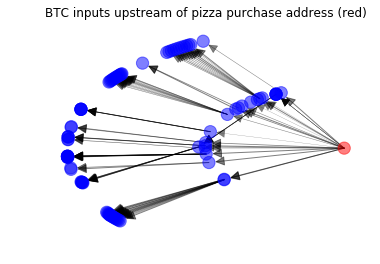

In [114]:
f = plt.figure()
nx.draw_networkx(graph, pos,
  with_labels = False,
  alpha = 0.5,
  node_size = 150,
  node_color = node_colors,
  width = edge_widths / 4,
  arrowsize = 20,
  ax=f.add_subplot(111))
plt.title("BTC inputs upstream of pizza purchase address (red)")
plt.axis('off')
f.savefig("graph.png")